# Easy Feature Subset selection with Estimation of Distribution Algorithms

It can be used as a simple example of EDA, or to use it for feature selection. The cost function to optimize is the metric of the model. An example is shown.

In [1]:
# loading essential libraries first
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# EDAspy libraries
from EDAspy.optimization.univariate import EDA_discrete as EDAd

We will use a small dataset to show an example of usage. We usually use a Feature Subset selector when a great amount of variables is available to use

In [4]:
# import some data
mdata = sm.datasets.macrodata.load_pandas().data
df = mdata.iloc[:, 2:]
df.head()

,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [6]:
variables = list(df.columns)
variable_y = 'pop'  # pop is the variable we want to forecast
variables = list(set(variables) - {variable_y})  # array of variables to select among transformations
variables

['realgdp',
 'm1',
 'realdpi',
 'realinv',
 'unemp',
 'tbilrate',
 'realgovt',
 'infl',
 'cpi',
 'realint',
 'realcons']

We define a cost function which receives a dictionary with variables names as keys of the dictionary and values 1/0 if they are used or not respectively.

The functions returns the Mean Absolute Error found with the combination of variables selected.

In [15]:
def cost_function(variables_dict, nobs=20, maxlags=10, forecastings=10):
    """
    variables_list: dictionary of variables without the variable_y with 1 if the variable is taken
    nobs: how many observations for validation
    maxlags: previous lags used to predict
    forecasting: number of observations to predict
    
    return: MAE of the prediction with the real validation data
    """
    
    aux = list(variables_dict.keys())
    variables_list = []
    for i in aux:
        if variables_dict[i] == 1:
            variables_list.append(i)
    
    data = df[variables_list + [variable_y]]

    df_train, df_test = data[0:-nobs], data[-nobs:]

    model = VAR(df_train)
    results = model.fit(maxlags=maxlags, ic='aic')

    lag_order = results.k_ar
    array = results.forecast(df_train.values[-lag_order:], forecastings)

    variables_ = list(data.columns)
    position = variables_.index(variable_y)

    validation = [array[i][position] for i in range(len(array))]
    mae = mean_absolute_error(validation, df_test['pop'][-forecastings:])
    
    return mae

We calculate the MAE found using all the variables.

This is an easy example so the difference between the MAE found using all the variables and the MAE found after optimizing the model, will be very small. But this is appreciated with more difference when large datasets are used

In [17]:
# build the dictionary with all 1s
dic = {}
for var in variables:
    dic.update({var: 1})

mae_pre_eda = cost_function(dic)
print('MAE without using EDA:', mae_pre_eda)

MAE without using EDA: 7.061634567114498


Initial vector of statistics. We usually start with all the variables with 50% of probability to be chosen. If desired, a variable can be deleted from the beggining just assigning a 0 probability to be chosen in the pandas dataframe

In [36]:
vector = pd.DataFrame(columns=variables)
vector.loc[0] = 0.5

In [37]:
history = []

Execute the algorithm. We must define:
1. Maximum number of iterations
2. Number of iterations after which, if the cost is not improved, the algorithm finishes
3. Number of individuals in each generation
4. Percetage (over 1) of population to be selected to mutate
5. vector of statistics
6. The cost function to optimize
7. Aim: 'minimize' or 'maximize'

The algorithm returns the best cost, a pandas dataframe with the solution found, and the history of costs

In [38]:
EDA = EDAd(MAX_IT=100, DEAD_ITER=10, SIZE_GEN=30, ALPHA=0.5, vector=vector, 
           cost_function=cost_function, aim='minimize')

bestcost, solution, history = EDA.run(output=True)

IT  0 best cost  6.582476132682814
['m1', 'realdpi', 'realinv', 'tbilrate', 'realgovt']
IT  1 best cost  6.620166924126318
['realgdp', 'm1', 'realdpi', 'unemp', 'realgovt', 'infl']
IT  2 best cost  6.402230084599393
['m1', 'realdpi', 'unemp', 'tbilrate', 'realgovt', 'infl', 'realint', 'realcons']
IT  3 best cost  6.402230084599393
['m1', 'realdpi', 'unemp', 'tbilrate', 'realgovt', 'infl', 'realint', 'realcons']
IT  4 best cost  6.464232129737877
['m1', 'realdpi', 'realinv', 'tbilrate', 'realgovt', 'infl', 'realint', 'realcons']
IT  5 best cost  6.452869182055804
['m1', 'realdpi', 'unemp', 'tbilrate', 'infl', 'realint', 'realcons']
IT  6 best cost  6.458211128939541
['realgdp', 'm1', 'realdpi', 'realinv', 'unemp', 'tbilrate', 'infl', 'realint', 'realcons']
IT  7 best cost  6.458211128939541
['realgdp', 'm1', 'realdpi', 'realinv', 'unemp', 'tbilrate', 'infl', 'realint', 'realcons']
IT  8 best cost  6.458211128939541
['realgdp', 'm1', 'realdpi', 'realinv', 'unemp', 'tbilrate', 'infl', 're

In [39]:
print('Best cost found:', bestcost)
print(solution)

Best cost found: 6.402230084599393
['m1', 'realdpi', 'unemp', 'tbilrate', 'realgovt', 'infl', 'realint', 'realcons']


# Some plots

Solution: ['m1', 'realdpi', 'unemp', 'tbilrate', 'realgovt', 'infl', 'realint', 'realcons'] 
MAE post EDA: 6.40 
MAE pre EDA: 7.06


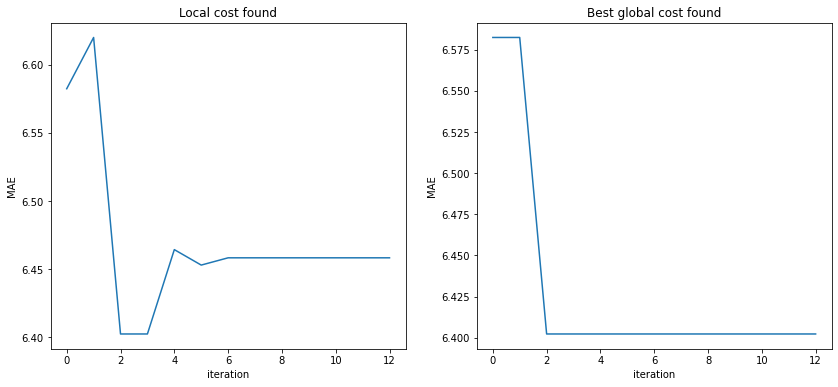

In [47]:
# some plots

relative_plot = []
mx = 999999999
for i in range(len(history)):
    if history[i] < mx:
        mx = history[i]
        relative_plot.append(mx)
    else:
        relative_plot.append(mx)

print('Solution:', solution, '\nMAE post EDA: %.2f' % bestcost, '\nMAE pre EDA: %.2f' % mae_pre_eda)

plt.figure(figsize = (14,6))

ax = plt.subplot(121)
ax.plot(list(range(len(history))), history)
ax.title.set_text('Local cost found')
ax.set_xlabel('iteration')
ax.set_ylabel('MAE')

ax = plt.subplot(122)
ax.plot(list(range(len(relative_plot))), relative_plot)
ax.title.set_text('Best global cost found')
ax.set_xlabel('iteration')
ax.set_ylabel('MAE')

plt.show()